# A* Maze Pathfinding (Notebook)

This notebook runs the `AStar.py` maze pathfinding with Catmull-Rom smoothing and distance-map safety. It uses the PNG map configured in `path_config.json` (key: `map_file`).

## Requirements
Run the next cell to install runtime dependencies:
- numpy
- matplotlib
- opencv-python
- pillow
- scipy
- numba (optional speedup)
- cupy (optional GPU; install separately per CUDA version)

> Note: The notebook expects `pythonrobotics` repo at `/Users/umutozdemir/Desktop/pythonrobotics` (already used by `AStar.py`).


In [14]:
# Install core dependencies (edit if you already have an env)
%pip install -q numpy matplotlib opencv-python pillow scipy numba


In [18]:
# AUTO-SETUP FOR GOOGLE COLAB
# If you're in Colab and AStar.py is not found, this will clone the repo
from pathlib import Path
import os

if not (Path('.') / 'AStar.py').exists():
    print("AStar.py not found. Attempting to clone repository...")
    try:
        # Check if we're in Colab
        if os.path.exists('/content'):
            print("Detected Google Colab environment")
            robotics_path = Path('/content/Robotics')
            
            if not robotics_path.exists():
                print("Cloning Robotics repository...")
                result = os.system('git clone https://github.com/SyntheticVis-Umut/Robotics.git /content/Robotics 2>&1')
                if result != 0:
                    print("⚠ Git clone failed. Trying alternative method...")
                    os.system('cd /content && git clone https://github.com/SyntheticVis-Umut/Robotics.git')
                    robotics_path = Path('/content/Robotics')
            
            # Check if AStar.py exists in the cloned repo
            if robotics_path.exists():
                print(f"\nChecking repository contents...")
                print(f"Repository location: {robotics_path}")
                
                # List Python files in the repo
                py_files = list(robotics_path.glob('*.py'))
                print(f"Python files found: {[f.name for f in py_files[:10]]}")
                
                # Check for AStar.py
                astar_file = robotics_path / 'AStar.py'
                if astar_file.exists():
                    os.chdir(str(robotics_path))
                    print(f"✓ Repository cloned successfully!")
                    print(f"✓ Found AStar.py at: {astar_file}")
                    print(f"✓ Changed to Robotics directory: {os.getcwd()}")
                else:
                    # Search recursively
                    print("\nSearching for AStar.py recursively...")
                    found_files = list(robotics_path.rglob('AStar.py'))
                    if found_files:
                        print(f"✓ Found AStar.py at: {found_files[0]}")
                        os.chdir(str(found_files[0].parent))
                        print(f"✓ Changed to directory: {os.getcwd()}")
                    else:
                        print("⚠ AStar.py not found in repository")
                        print(f"Repository structure:")
                        for item in sorted(robotics_path.iterdir())[:20]:
                            print(f"  - {item.name} ({'dir' if item.is_dir() else 'file'})")
            else:
                print("⚠ Repository directory not created")
        else:
            print("Not in Colab. Please clone manually or set ROOT path in next cell.")
    except Exception as e:
        print(f"⚠ Could not auto-clone: {e}")
        import traceback
        traceback.print_exc()
        print("\nPlease clone manually or upload AStar.py")
else:
    print("✓ AStar.py already found in current directory")


AStar.py not found. Attempting to clone repository...
Detected Google Colab environment
Cloning Robotics repository...

Checking repository contents...
Repository location: /content/Robotics
Python files found: ['Dijkstra.py', 'PSO.py', 'AStar.py', 'HybridAStar.py']
✓ Repository cloned successfully!
✓ Found AStar.py at: /content/Robotics/AStar.py
✓ Changed to Robotics directory: /content/Robotics


In [19]:
# DIRECT DOWNLOAD: Get AStar.py directly from GitHub
# Run this cell if git clone failed above
from pathlib import Path
import urllib.request
import os

if not (Path('/content') / 'AStar.py').exists() and not (Path('.') / 'AStar.py').exists():
    print("Attempting to download AStar.py from GitHub...")
    print("="*70)
    
    # Try different branch names
    branches = ['main', 'master', 'master']  # Try main first, then master
    base_url = "https://raw.githubusercontent.com/SyntheticVis-Umut/Robotics"
    output_path = Path('/content/AStar.py')
    
    downloaded = False
    for branch in branches:
        url = f"{base_url}/{branch}/AStar.py"
        print(f"\nTrying branch '{branch}': {url}")
        try:
            urllib.request.urlretrieve(url, output_path)
            if output_path.exists() and output_path.stat().st_size > 0:
                print(f"✓ Successfully downloaded AStar.py from '{branch}' branch!")
                print(f"✓ File location: {output_path}")
                print(f"✓ File size: {output_path.stat().st_size} bytes")
                os.chdir('/content')
                print(f"✓ Changed to /content directory")
                downloaded = True
                break
        except urllib.error.HTTPError as e:
            print(f"  ✗ HTTP {e.code}: {e.reason}")
        except Exception as e:
            print(f"  ✗ Error: {e}")
    
    if not downloaded:
        print("\n" + "="*70)
        print("⚠ Could not download from GitHub (404 errors)")
        print("="*70)
        print("This usually means:")
        print("1. The repository is private, OR")
        print("2. The branch name is different, OR")
        print("3. The file path is different")
        print("\nSOLUTIONS:")
        print("="*70)
        print("Option 1: Upload AStar.py manually (RECOMMENDED)")
        print("  - Click the folder icon in Colab sidebar")
        print("  - Click 'Upload' button")
        print("  - Select AStar.py from your local machine")
        print("  - It will be saved to /content/AStar.py")
        print("\nOption 2: Use Google Drive")
        print("  - Upload AStar.py to Google Drive")
        print("  - Mount drive: from google.colab import drive; drive.mount('/content/drive')")
        print("  - Copy: !cp /content/drive/MyDrive/AStar.py /content/")
        print("\nOption 3: Check GitHub repository")
        print("  - Visit: https://github.com/SyntheticVis-Umut/Robotics")
        print("  - Find the correct branch and file path")
        print("  - Update the URL in this cell")
        print("="*70)
else:
    if (Path('/content') / 'AStar.py').exists():
        print("✓ AStar.py already exists at /content/AStar.py")
    elif (Path('.') / 'AStar.py').exists():
        print("✓ AStar.py already exists in current directory")


✓ AStar.py already exists in current directory


In [23]:
import os, sys, importlib
from pathlib import Path
import importlib.util
import matplotlib.pyplot as plt

# ============================================================================
# IMPORTANT: If auto-detection fails, uncomment and set ROOT manually below:
# ============================================================================
# ROOT = Path('/Users/umutozdemir/Desktop/Robotics')  # Local Mac path
# ROOT = Path('/content')  # Google Colab (after uploading AStar.py)
# ROOT = Path('/path/to/your/Robotics')  # Your custom path
# ============================================================================

# Auto-detect - try multiple possible locations
ROOT = None

possible_roots = [
    Path('/Users/umutozdemir/Desktop/Robotics'),  # Original location
    Path('/content'),  # Google Colab (AStar.py downloaded here)
    Path('/content/Robotics'),  # Google Colab cloned location
    Path.cwd(),  # Current working directory
]

# Search for AStar.py
for root in possible_roots:
    if root and root.exists():
        astar_file = root / 'AStar.py'
        if astar_file.exists():
            ROOT = root
            break

# If still not found, search in current directory and parents
if ROOT is None:
    cwd = Path.cwd()
    # Check current directory
    if (cwd / 'AStar.py').exists():
        ROOT = cwd
    else:
        # Check parent directories (up to 3 levels up)
        for parent in [cwd.parent, cwd.parent.parent, cwd.parent.parent.parent]:
            if (parent / 'AStar.py').exists():
                ROOT = parent
                break

# If still not found, try to find it by searching common locations
if ROOT is None:
    print("Searching for AStar.py in common locations...")
    search_paths = [
        Path.home() / 'Desktop' / 'Robotics',
        Path.home() / 'Documents' / 'Robotics',
        Path('/content'),  # Google Colab
    ]
    for search_path in search_paths:
        if search_path.exists() and (search_path / 'AStar.py').exists():
            ROOT = search_path
            print(f"Found AStar.py at: {ROOT}")
            break

if ROOT is None:
    print("=" * 70)
    print("⚠ AStar.py not found automatically")
    print("=" * 70)
    print(f"Current working directory: {Path.cwd()}")
    print(f"Python files in current directory: {list(Path.cwd().glob('*.py'))}")
    print("\nSOLUTIONS:")
    print("1. If you're in Google Colab/Jupyter:")
    print("   - Upload AStar.py to the same directory as this notebook")
    print("   - Or uncomment and set ROOT manually above")
    print("2. If running locally:")
    print("   - Make sure this notebook is in the Robotics directory")
    print("   - Or set ROOT manually to point to the Robotics directory")
    print("\nTo set manually, uncomment this line at the top of this cell:")
    print("   ROOT = Path('/path/to/your/Robotics')")
    print("=" * 70)
    
    # Try to continue anyway - maybe the user will upload it
    # But we'll set ROOT to current directory as a fallback
    ROOT = Path.cwd()
    print(f"\n⚠ Using current directory as ROOT: {ROOT}")
    print("If AStar.py is not here, please upload it or set ROOT manually.")

# Ensure project root on sys.path and set cwd
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))
os.chdir(ROOT)
print('✓ Project root:', ROOT)

# Path to pythonrobotics repo (used inside AStar.py)
PR_ROOT = Path('/Users/umutozdemir/Desktop/pythonrobotics')
if not PR_ROOT.exists():
    # Try Colab location
    PR_ROOT = Path('/content/pythonrobotics')
    if not PR_ROOT.exists():
        # fallback: sibling of ROOT
        PR_ROOT = ROOT.parent / 'pythonrobotics'

# Clone pythonrobotics if not found (especially in Colab)
if not PR_ROOT.exists():
    print('⚠ pythonrobotics not found. Attempting to clone...')
    try:
        import subprocess
        if os.path.exists('/content'):
            # In Colab, clone to /content/pythonrobotics
            clone_path = Path('/content/pythonrobotics')
            if not clone_path.exists():
                print("Cloning pythonrobotics repository...")
                result = subprocess.run(
                    ['git', 'clone', 'https://github.com/AtsushiSakai/PythonRobotics.git', str(clone_path)],
                    capture_output=True,
                    text=True,
                    timeout=120
                )
                if result.returncode == 0:
                    PR_ROOT = clone_path
                    print(f"✓ Successfully cloned pythonrobotics to {PR_ROOT}")
                else:
                    print(f"⚠ Git clone failed: {result.stderr}")
                    print("Trying alternative: use !git clone in a new cell")
        else:
            print("Not in Colab. Please clone pythonrobotics manually or set PR_ROOT path.")
    except Exception as e:
        print(f"⚠ Could not clone pythonrobotics: {e}")

if PR_ROOT.exists() and str(PR_ROOT) not in sys.path:
    sys.path.insert(0, str(PR_ROOT))
    print('✓ pythonrobotics path:', PR_ROOT)
else:
    print('⚠ pythonrobotics path: not found (some features may not work)')
    print('  You may need to clone it manually:')
    print('  !git clone https://github.com/AtsushiSakai/PythonRobotics.git /content/pythonrobotics')

# Load AStar module directly from file path
astar_path = ROOT / 'AStar.py'
if not astar_path.exists():
    print("\n" + "=" * 70)
    print("❌ ERROR: AStar.py still not found!")
    print("=" * 70)
    print(f"Looked for: {astar_path}")
    print("\nPlease:")
    print("1. Upload AStar.py to this location, OR")
    print("2. Set ROOT manually at the top of this cell to point to the Robotics directory")
    print("=" * 70)
    raise FileNotFoundError(f"AStar.py not found at {astar_path}")

# Patch AStar.py's hardcoded path before loading
# Read the file, replace the hardcoded path, and load from string
if PR_ROOT.exists():
    # Read AStar.py content
    with open(astar_path, 'r') as f:
        astar_code = f.read()
    
    # Replace hardcoded path with our PR_ROOT
    old_path = "/Users/umutozdemir/Desktop/pythonrobotics"
    if old_path in astar_code and str(PR_ROOT) not in astar_code:
        astar_code = astar_code.replace(
            f"sys.path.insert(0, '{old_path}')",
            f"sys.path.insert(0, r'{PR_ROOT}')"
        )
        # Write modified code to a temporary file
        temp_astar = ROOT / 'AStar_temp.py'
        with open(temp_astar, 'w') as f:
            f.write(astar_code)
        astar_path = temp_astar
        print(f"✓ Patched AStar.py to use pythonrobotics at {PR_ROOT}")

# Ensure pythonrobotics is in sys.path before loading
if PR_ROOT.exists() and str(PR_ROOT) not in sys.path:
    sys.path.insert(0, str(PR_ROOT))

spec = importlib.util.spec_from_file_location("AStar", astar_path)
AStar = importlib.util.module_from_spec(spec)
sys.modules["AStar"] = AStar
spec.loader.exec_module(AStar)

print('✓ Loaded AStar module from', astar_path)


✓ Project root: /content/Robotics
⚠ pythonrobotics not found. Attempting to clone...
Cloning pythonrobotics repository...
✓ Successfully cloned pythonrobotics to /content/pythonrobotics
✓ pythonrobotics path: /content/pythonrobotics
✓ Patched AStar.py to use pythonrobotics at /content/pythonrobotics
[GPU] ✗ GPU acceleration not available
[GPU] Install cupy for GPU support: pip install cupy-cuda11x
[Numba] ✓ JIT compilation available
✓ Loaded AStar module from /content/Robotics/AStar_temp.py


In [24]:
# Load config and maze
cfg = AStar.load_planner_config()
print('Config:', cfg)

maze = AStar.load_maze_from_maps()
if maze is None:
    print('Falling back to generated maze')
    maze = AStar.create_maze()

print('Maze size:', maze.width, 'x', maze.height)
print('Start:', maze.start, 'Exit:', maze.exit)


Config: {'use_distance_cost': True, 'num_points_per_segment': 15, 'show_distance_map': True, 'smoothing_enabled': True, 'distance_heat_gamma': 0.05, 'detection_mode': 'canny', 'canny_threshold1': 100, 'canny_threshold2': 200}
Loading maze from image: sophisticated_maze.png
Using detection mode: canny
Canny edge map saved to: /content/Robotics/maps/canny.png
Successfully loaded maze: 60x60
Start position: (33.0, 25.0)
Exit position: (48.0, 57.0)
Maze size: 60 x 60
Start: (33.0, 25.0) Exit: (48.0, 57.0)


[Distance Map] Computing distance field...
[Distance Map] ✓ Distance field computed successfully
Finding path using A* algorithm...
[A*] Distance field available for safety-aware pathfinding
min_x: 0
min_y: 0
max_x: 59
max_y: 59
x_width: 59
y_width: 59
[A*] ✓ Distance field cost enabled
[GPU] ✗ GPU not available, using CPU for obstacle map
[CPU] ✓ Using optimized CPU (NumPy) for obstacle map
[A*] Starting pathfinding from (33.0, 25.0) to (48.0, 57.0)
[A*] Using CPU pathfinding with Numba JIT compilation
Open set is empty..
[Spline] Applying Catmull-Rom spline smoothing to A* path...
[Spline] ✓ Smoothed path is collision-free (1 points)
Path found! Path length: 1 steps
Explored 1313 nodes
Displaying visualization...


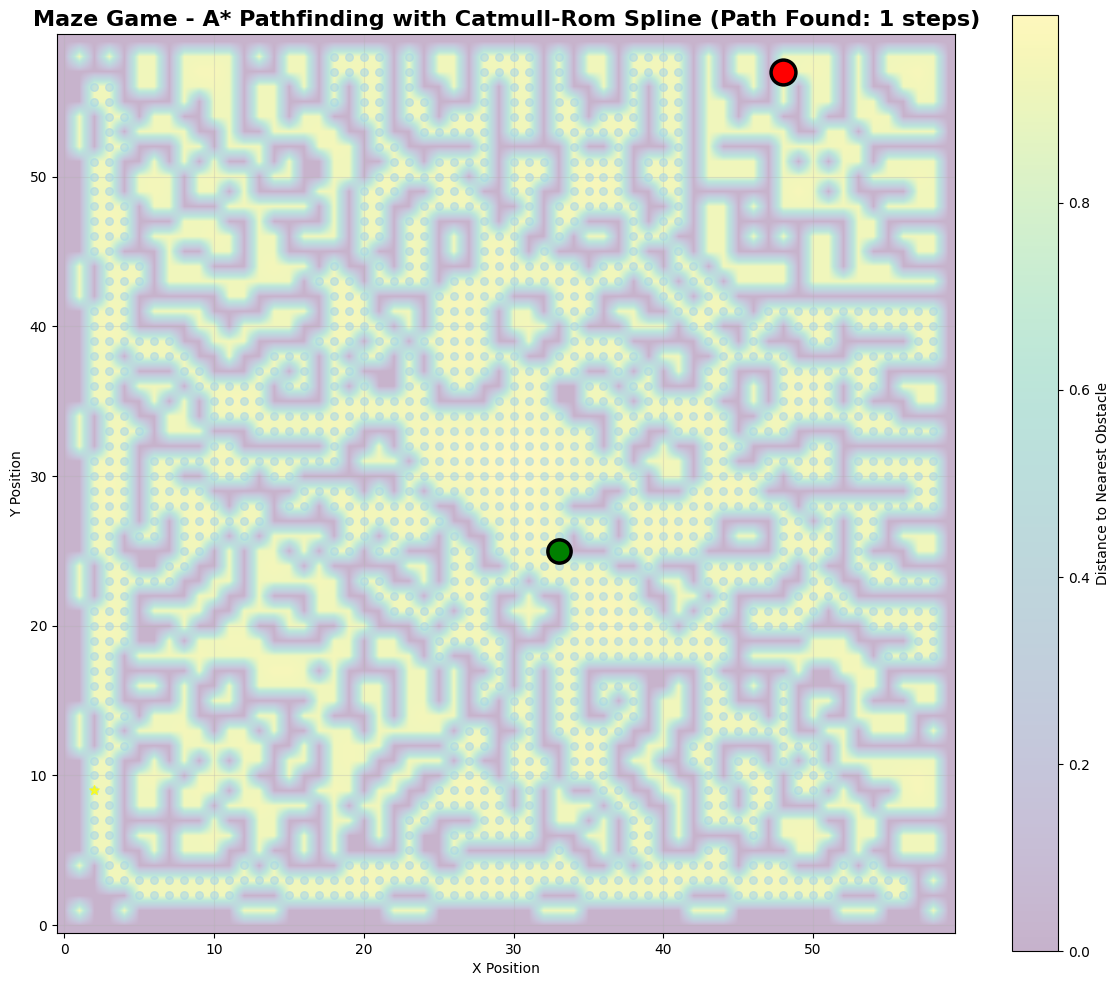

In [25]:
# Run pathfinding and visualize
%matplotlib inline

game = AStar.MazeGame(maze)
game.run()
